[![Open in
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slitvinov/odil-examples/blob/main/iterations.ipynb)

# Explanation of the Wave Equation Solver

This notebook cell implements a **least-squares solution** of the **1D wave equation** on a space–time grid.

---

## 1. The PDE

We want to solve the **1D wave equation**:

$$
u_{tt} - u_{xx} = 0, \quad (t,x) \in [0,T]\times[-L,L]
$$

with conditions:

- **Initial condition (at \(t=0\)):**
$$
u(0,x) = \exp\!\Big(-\frac{x^2}{\sigma^2}\Big)
$$

- **Boundary conditions (at \(x=-L,\,x=L\)):**
$$
u(t, -L) = u(t, L) = 0
$$

- **Terminal condition (at \(t=T\)):**
$$
u(T, x) = 0
$$

---

## 2. Discretization

We discretize the domain with:
- \(nx\) spatial points, spacing
$$
dx = \frac{2L}{nx-1}
$$
- \(nt\) time points, spacing
$$
dt = \frac{T}{nt}
$$

The centered finite-difference approximation of the wave operator is:

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{dt^2}
-
\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{dx^2} = 0
$$

which, after rearrangement, gives coefficients:

$$
c_1 = \frac{1}{2 dt^2}, \quad
c_0 = -\frac{1}{2 dx^2}, \quad
c_2 = -\frac{dx^2 - dt^2}{dt^2 dx^2}.
$$

Thus, each interior equation couples five unknowns:

$$
c_1 u_{i-1,j} + c_0 u_{i,j-1} + c_2 u_{i,j} + c_0 u_{i,j+1} + c_1 u_{i+1,j} = 0
$$

---

## 3. Sparse matrix construction

The code builds two sparse matrices:

- **`dF` (PDE + boundary + terminal constraints):**  
  - For interior nodes, encodes the wave stencil above.  
  - For boundary/terminal nodes, enforces $$u=0$$ by inserting identity rows.

- **`dG` (initial condition at \(t=0\)):**  
  - At $$t=0$$, enforces
    $$
    u(0,x_j) = \exp\!\Big(-\frac{x_j^2}{\sigma^2}\Big)
    $$
    via identity rows.  
  - Elsewhere, adds no extra constraint.

Both are stored in **CSR sparse format**.

---

## 4. Least-squares formulation

We formulate the problem as a minimization of a loss function, which is a sum of squared residuals for the PDE and the boundary/initial conditions. This is a common approach in the ODIL (Operator Discretization and Inference Library) framework.

The loss function is:
$
L(u) = \|F[u]\|_2^2 + \|G[u]\|_2^2
$

For a linear problem like the wave equation, the discrete operators `F[u]` and `G[u]` can be written in the form `dF * u - f` and `dG * u - g` respectively.

So we want to minimize:
$
\min_u \; \|dF u - f\|_2^2 + \|dG u - g\|_2^2
$

where:
- `u` is the vector of all unknown values `u_{i,j}` at each grid point, flattened into a single vector of size `nt * nx`.
- `dF` is the sparse matrix representing the discretized wave operator and the zero boundary/terminal conditions.
- `f` is a vector of zeros, as the PDE and boundary/terminal conditions are homogeneous (equal to zero).
- `dG` is a sparse matrix that selects the values of `u` at `t=0`.
- `g` is a vector containing the target values for the initial condition. It has `exp(-x_j^2/sigma^2)` for `t=0` and zeros elsewhere. The expression `dG * u - g` is constructed such that for `t=0` it becomes `u(0, x_j) - exp(-x_j^2/sigma^2)`, and we are minimizing the square of this difference.

This is a standard linear least-squares problem. The solution is found by solving the **normal equations**:
$
(dF^T dF + dG^T dG) u = dF^T f + dG^T g
$

The code implements an iterative solver for this system. The matrix `M = dF^T dF + dG^T dG` is the Hessian of the loss function. The right-hand side is the negative gradient of the loss at `u=0`. The code performs several iterations, but since the problem is linear, a single step is sufficient to find the exact solution. The iterative updates are computed as:
$
M u_{new} = M u_{old} - (dF^T(dF u_{old} - f) + dG^T(dG u_{old} - g))
$
which simplifies to
$
M u_{new} = dF^T f + dG^T g
$
if `u_old` is zero. The code uses a slightly different formulation for the right hand side `rhs = -M @ us + dF.T @ Fs + dG.T @ Gs` which is equivalent to `rhs = dF.T @ f + dG.T @ g` when `us` is the solution of the previous iteration.

diff: 6.1039e-02
diff: 8.9607e-14
diff: 5.1230e-14
diff: 4.3460e-14
diff: 2.4786e-15


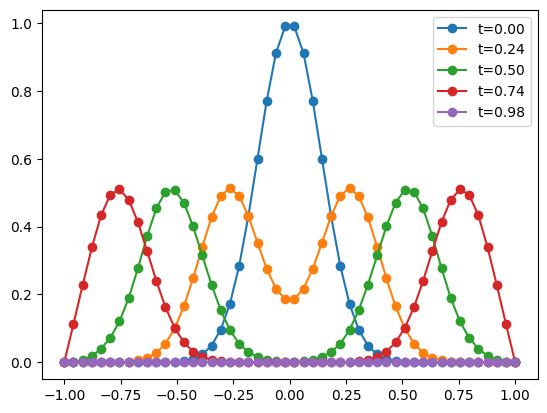

In [5]:
import scipy
import matplotlib.pyplot as plt
import math
import numpy as np


def cappend(i, j, d):
    row.append(len(rhs))
    col.append(i * nx + j)
    data.append(d)


nx = 50
nt = 50
L = 1.0
T = 1.0
sigma = 0.2
dx = 2 * L / (nx - 1)
dt = T / nt
c0 = -1 / (2 * dx**2)
c1 = 1 / (2 * dt**2)
c2 = -((dx**2 - dt**2) / (dt**2 * dx**2))
x = np.linspace(-L, L, nx)

# dF for PDE at interior points
row = []
col = []
rhs = []
data = []
for i in range(1, nt - 1):
    for j in range(1, nx - 1):
        cappend(i - 1, j, c1)
        cappend(i, j - 1, c0)
        cappend(i, j, c2)
        cappend(i, j + 1, c0)
        cappend(i + 1, j, c1)
        rhs.append(0)
dF = scipy.sparse.csr_matrix((data, (row, col)), shape=(len(rhs), nt * nx), dtype=float)
f = np.array(rhs, dtype=float)

# dG for initial, boundary and terminal conditions
row = []
col = []
rhs = []
data = []
for i in range(nt):
    for j in range(nx):
        if i == 0:
            # Initial condition
            cappend(i, j, 1)
            rhs.append(math.exp(-(x[j] / sigma)**2))
        elif i == nt - 1:
            # Terminal condition
            cappend(i, j, 1)
            rhs.append(0)
        elif j == 0 or j == nx - 1:
            # Boundary conditions
            cappend(i, j, 1)
            rhs.append(0)
dG = scipy.sparse.csr_matrix((data, (row, col)), shape=(len(rhs), nt * nx), dtype=float)
g = np.array(rhs, dtype=float)

us = np.zeros(nt * nx)
for i in range(5):
    Fs = dF @ us - f
    Gs = dG @ us - g
    M = dF.T @ dF + dG.T @ dG
    rhs = M @ us - dF.T @ Fs - dG.T @ Gs
    usp = scipy.sparse.linalg.spsolve(M, rhs)
    print(f"diff: {np.mean((usp - us)**2):8.4e}")
    us = usp
u = np.asarray(us).reshape(nt, nx)
for k in 0, nt // 4, nt // 2, 3 * nt // 4, nt - 1:
    plt.plot(x, u[k, :], 'o-', label=f"t={k*dt:.2f}")
plt.legend();